# Subreddit Predictor

We will try to train a ML model which can predict which subreddit a specific post belongs to.
For simplicity we will select a small number of subreddits that our model will have to choose between.
top_subreddits = ['announcements', 'funny', 'AskReddit', 'dataisbeautiful', 'Awww', 'datascience', 'pics', 'science', 'worldnews', 'videos', 'AmItheAsshole']

In [ ]:
import pandas as pd
import praw
import secrets
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.svm import SVC
import matplotlib.pyplot as plt


## Gather the Data
PushShift is down, which means we will stick with praw and are limited on the amount of data we can gather.
We will hand select a

In [ ]:
user_agent = "Subreddit-Predictor 0.2 by /u/IsThisATrollBot"

reddit = praw.Reddit(
    client_id=secrets.client_ID,
    client_secret=secrets.client_secret,
    password=secrets.password,
    user_agent=user_agent,
    username=secrets.username,
)

In [ ]:
# Start with a list of subreddits
top_subreddits = ['announcements', 'funny', 'AskReddit', 'dataisbeautiful', 'Awww', 'datascience', 'pics', 'science', 'worldnews', 'videos', 'AmItheAsshole']

In [ ]:
# Create an empty list to store the posts
posts = []

# Iterate through the subreddits and get the last 1000 posts from each
for sub in top_subreddits:
    subreddit_posts = reddit.subreddit(sub).new(limit=1000)
    for post in subreddit_posts:
        posts.append(post)

In [ ]:
# Create a list of dictionaries containing the data for each post
data = [{'id': post.id, 'title': post.title, 'subreddit': post.subreddit.display_name} for post in posts]

# Create a Pandas dataframe from the list of dictionaries
df = pd.DataFrame(data)

df

,id,title,subreddit
0,t93ec3,This subreddit is closed for new posts and com...,announcements
1,pg006s,COVID denialism and policy clarifications,announcements
2,pbmy5y,"Debate, dissent, and protest on Reddit",announcements
3,nw2hs6,Sunsetting Secret Santa and Reddit Gifts,announcements
4,mi01fg,Second,announcements
...,...,...,...
9539,zuadbh,WIBTA for asking my dad not to bring his gf to...,AmItheAsshole
9540,zu9skp,AITA for not going to my mom’s house for Chris...,AmItheAsshole
9541,zu9ru7,AITA for wanting my husband to man up and conf...,AmItheAsshole
9542,zu9pgh,AITA for telling my friend to mind her own bus...,AmItheAsshole


# Class: Subreddit_Predictor

Objects of this class contain attributes and Methods that can be broken up into three categories: **Data**, **Collections**, and **Processing**

## Data
Pandas DataFrames and methods to update and clean the data.

**Attributes:**

| Name      |   Type    |             Description             |
|:----------|:---------:|:-----------------------------------|
| raw_data  | DataFrame |      The raw unprocessed data       |
| full_data | DataFrame |         The processed data          |
| subreddits |   list    | A list of subreddits. Extraced from full_data. |
| X_train   | pd.Series | the X portion of the training data  |
| Y_train   | np.array  | the Y portion of the training data  |
| X_test    | pd.Series |   the X portion of the test data    |
| Y_test    | np.array  |   the Y portion of the test data    |

**Methods:**

| Name (with input/output typing) | Description                                                                                                                               |
|---------------------------------| ------------------------------------------------------------------------------------------------------------------------------------------|
| add_data(df: DataFrame)         | Updates the raw_data attribute                                                                                                            |
| ready_data()                    | Cleans the data and does a test train split. <br/> Overwrites the full_data attribute. <br/> Creates the X_train, Y_train, X_test, and Y_test attributes. |

## Collections
Contains dictionaries of vectorizers, classifiers, and models

**Attributes:**

| Name        | Type                  | Description                                                                                                                                |
|:------------|:----------------------|:-------------------------------------------------------------------------------------------------------------------------------------------|
| Vectorizers | dict | Dictionary of Vectorizer objects                                                                                                           |
| Feature_Vectors | dict | Dictionary of the vectorized full_data |
| Classifiers | dict | Dictionary of Classifier objects                                                                                                           |
| Models      | dict | Dictionary of trained Classifier objects                                                                                                   |
| Models_info | dict        | Dictionary containing a description of each model in Models.                                                                               |
| Predictions | DataFrame   | A DataFrame with all the titles and actual subreddits in X_test and Y_test <br/> There is a column for each model that has the predictions |
| Results | dict | Dictionary of DataFrames for each model. Each row and column is a subreddit. Shows the number of false classifications |

**Methods:**

| Name (with input/output typing)                                                                                  | Description                                                                                                                                                                                |
|------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| add_vectorizer(model: Vectorizer)                                                                                | Trains the vectorizer. <br/>Adds (key = model.name, value = model) to Vectorizers                                                                                                               |
| add_feature_vectors(vectorizerName: str)| Embeds X_train as vectors and creates a dataframe for the new feature vectors. <br/> Adds this dataFrame to Feature_Vectors |
| add_classifier(model: Classifier)                                                                                | Adds (key = model.name, value = model) to Classifiers                                                                                                                                      |
| train_model(<br/>modelName: str, <br/>vectorizerName: str, <br/>classifierName: str, <br/>description = '' :str) | Takes vectorizer and classifer from Vectorizers and Classifiers. <br/>Trains the classifier.<br/>Names and adds the trained model to Models.<br/>Adds the description text to Models_info. |
| test_model(modelName: str) | Runs the model against X_test and Y_test. <br/> Updates Predictions and Results                                                                                                            |

## Processing

**Methods:**

| Name (with input/output typing)                       | Description                                                                                   |
|-------------------------------------------------------|-----------------------------------------------------------------------------------------------|
| predict(modelName:str, title: str, titles: iter[str]) | Given a model, enter a title or a list/dataframe of titles. Will return the model prediction. |
| compare(models: list[str])                            | Creates a bar chart comparing each of the models on each of the subreddits. |                  |

In [ ]:
class Subreddit_Predictor:

    def __init__(self):

        #Data
        self.raw_data = pd.DataFrame({'id': [], 'title': [], 'subreddit': []})
        self.full_data = pd.DataFrame({'id': [], 'title': [], 'subreddit': []}).set_index('id')
        self.subreddits = []

        #Collections
        self.Vectorizers = {}
        self.Feature_Vectors = {}
        self.Classifiers = {}
        self.Models = {}
        self.Models_info = {}
        #self.Predictions = {}
        self.Results = {}

    #### Data ####

    def add_data(self, df):
        """df is a pandas DataFrame with columns={'title':[], 'subreddit':[]}. It will be merged with the existing raw_data"""
        self.raw_data = pd.concat([self.raw_data, df]).drop_duplicates(subset='id')

    def ready_data(self, test_size=.2, seed=42):
        """Splits and encodes the data. Saves is in X_train, Y_train, X_test, Y_test."""

        # Clean the data
        self._clean_data()

        # Update the subreddits attribute
        self.subreddits = self.full_data['subreddit'].unique().tolist()

        # Encode the subreddits
        self._le = LabelEncoder()
        self.full_data['subreddit_num'] = self._le.fit_transform(self.full_data['subreddit'])

        # Split the data
        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(self.full_data['title'],
                                                                                self._le.fit_transform(
                                                                                    self.full_data['subreddit']),
                                                                                test_size=test_size, random_state=seed)
        # Record the indices
        self._train_index = self.X_train.index
        self._test_index = self.X_test.index

        # Update Predictions
        df = self.full_data
        df = df.drop(columns=['subreddit_num'])
        df = df.loc[obj._test_index]
        df = df.rename(columns={'subreddit':'actual'})
        self.Predictions = df

    def _clean_data(self):
        """Cleans the data in raw_data and updates self.data"""

        df = self.raw_data

        # Remove all non-alpha-numeric characters
        df['title'] = df['title'].str.replace(r'[^a-zA-Z0-9 ]', '', regex=True)

        # Make all the text lowercase
        df['title'] = df['title'].str.lower()

        # Remove empty rows
        df['title'] = df['title'].str.strip()
        filter = df['title'] == ''
        df = df.drop(df[filter].index)

        # Store it as
        self.full_data = df

        # Change the index
        self.full_data = self.full_data.set_index('id')


    #### Collections ####

    def add_vectorizer(self, vectorizer):
        """This is how we add a vectorizers to our collection"""
        vectorizer.train(self.X_train)
        self.Vectorizers[vectorizer.vectorizerName] = vectorizer

    def add_feature_vectors(self, vectorizerName):
        """Updates Feature_Vectors"""
        vectorizer = self.Vectorizers[vectorizerName]
        self.Feature_Vectors[vectorizerName] = vectorizer.embed(self.full_data['title'])

    def add_classifier(self, classifier):
        """We add the classifier to our collection, self.Classifiers"""
        self.Classifiers[classifier.classifierName] = classifier

    def train_model(self, modelName, vectorizerName, classifierName, description = ''):
        """
        :param modelName: The name of this model
        :param vectorizerName: Which feature vectors are we using?
        :param classifierName: Which classifier are we using?
        :param description: Write a short discription of the model (optional).
        :return: Adds a trained object of the classifier class to self.Models
        """

        self.Models_info[modelName] = {'vectorizerName':vectorizerName, 'classifierName':classifierName, 'description':description}

        X_train = self.Feature_Vectors[vectorizerName].loc[self._train_index]
        Y_train = self.Y_train
        classifier = self.Classifiers[classifierName]
        classifier.train(X_train, Y_train)

        self.Models[modelName] = classifier

    def test_model(self, modelName):
        """Tests the model using X_test and Y_test. Updates Predictions and Results"""

        model = self.Models[modelName]

        vectorizerName = self.Models_info[modelName]['vectorizerName']
        X_test = self.Feature_Vectors[vectorizerName].loc[self._test_index]

        yhat = model.predict(X_test)
        yhat = self._le.inverse_transform(yhat)
        self.Predictions[modelName] = yhat


        df = self.Predictions
        results_matrix = pd.DataFrame(columns = self.subreddits)
        for actual_sub in self.subreddits:
            row = []
            filter = df['actual'] == actual_sub
            temp_df = df[filter]
            total = len(temp_df)
            for predicted_sub in self.subreddits:
                filter = temp_df[modelName] == predicted_sub
                count = len(temp_df[filter])
                row.append(count/total)

                #print('actual_sub', actual_sub, 'predicted_sub', predicted_sub)

            results_matrix.loc[actual_sub] = row

        self.Results[modelName] = results_matrix


    #### Processing ####

    def compare(self, list_of_models):
        """Creates a bar chart comparing the predictions from a list of models"""

        num_models = len(list_of_models)

        # Set the width of the bars
        bar_width = 1 / (num_models + 1)

        Results = self.Results

        keys = list(list(Results.items())[0][1].keys())
        x_pos = [i for i, _ in enumerate(keys)]

        for key, val in Results.items():
            correct = []
            for sub in self.subreddits: correct.append(val.loc[sub][sub])
            plt.bar(x_pos, correct, bar_width, label=key)
            x_pos = [i + bar_width for i in x_pos]

        x_pos = [i - bar_width for i in x_pos]

        # Set the x-axis tick labels
        plt.xticks(x_pos, keys, rotation=45, ha='right')

        # Add a title and axis labels
        plt.title('Which Subreddits were easiest to predict?')
        plt.xlabel('Subreddit')
        plt.ylabel('% Correct')

        # Add a legend
        plt.legend()

        # Show the plot
        plt.show()



In [ ]:
x.loc['hi']['title']

NameError: name 'x' is not defined

No training needed
[1 4 2 ... 1 2 7]


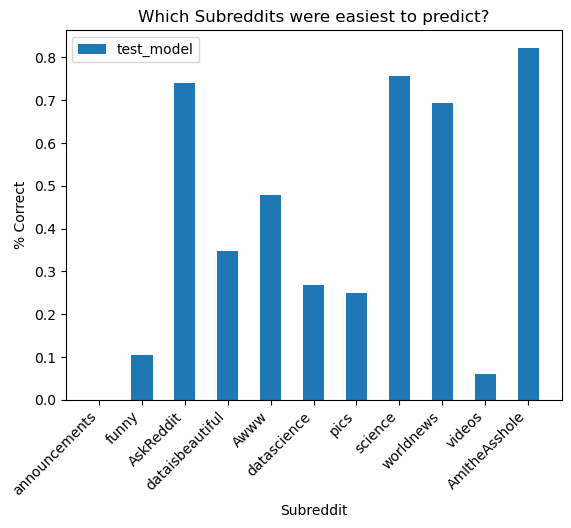

In [16]:
obj = Subreddit_Predictor()
obj.add_data(df)
obj.ready_data()
#obj.Predictions

count_embedding = Vectorizer('count')
count_embedding._embed = _count_embed
count_embedding._train = _count_train
obj.add_vectorizer(count_embedding)
obj.add_feature_vectors('count')

SVM_model = Classifier('SVM')
SVM_model._train = _SVM_train
SVM_model._predict = _SVM_predict
obj.add_classifier(SVM_model)

obj.train_model('test_model', 'count', 'SVM')
obj.test_model('test_model')

#obj.Predictions
#obj.Results['test_model']
obj.compare(['test_model'])

# Class: Vectorizer

Objects of this class are vectorizers, like Bag-of-Words or Doc2Vec. They have very few attributes and methods.
All of the attributes and methods will be overwritten by each object of this class.

**Attributes:**

| Name           | Type | Description                                                                                         |
|----------------|------|-----------------------------------------------------------------------------------------------------|
| vectorizerName | str | The name of this vectorizer. <br/> This will be the key for any dictionaries containing it.         |
| description    | str | A breif discription of what this vectorizer is/does. <br/>Put the parameters here if there are any. |
| model | Other | The actual model. Typically an object of a class like Gensim or SCM

**Methods:**

| Name                                  | Description                                                                                          |
|---------------------------------------|------------------------------------------------------------------------------------------------------|
| train(X_train: DataFrame)             | Uses the training data to train the model.                                                           |
| embed(titles: DataFrame) -> DataFrame | Takes a list/dataFrame of titles and returns a DataFrame of the embeddings for each of them. |



In [8]:
class Vectorizer:
    """This class is to hold all of the Title Vectorizers, like Bag-of-Words and Doc2Vec. Each vectorizer is a specific object. The class methods all have the same input/output."""

    def __init__(self, vectorizerName):
        self.vectorizerName = vectorizerName
        self.description = "Description goes here"

    def train(self, X_train):
        """Inputs the training data. Creates the self.model"""

        self.model = self._train(X_train)

    def _train(self, X_train):
        """Just a place holder for the actual function"""
        pass

    def embed(self, titles):
        """Given a data frame or series with only titles, will return a df of all of the features, indexed by id. The actual function will be added to each object."""

        return self._embed(titles, self.model)

    def _embed(self, titles, model):
        """Just a place holder for the actual function."""
        pass



## Example

In [9]:
import string

def count_letters(series):
    # Initialize an empty list to store the letter count dictionaries for each title
    letter_counts_list = []

    # Iterate over the values in the series
    for title in series:
        # Initialize a dictionary with 26 keys, one for each letter of the alphabet
        letter_counts = {letter: 0 for letter in string.ascii_lowercase}

        # Convert the title to lowercase and iterate over the characters in the title
        for char in title.lower():
            # If the character is a letter, increment the count for that letter in the dictionary
            if char in string.ascii_lowercase:
                letter_counts[char] += 1

        # Add the letter counts for the current title to the list
        letter_counts_list.append(letter_counts)

    # Convert the list of dictionaries to a pandas dataframe
    letter_counts_df = pd.DataFrame(letter_counts_list, index=series.index)

    return letter_counts_df


count_embedding = Vectorizer('count')

def _count_train(X_train):
    print('No training needed')
    return 'No training needed'

def _count_embed(titles, model):
    return count_letters(titles)

count_embedding._embed = _count_embed
count_embedding._train = _count_train


# Class: Classifier

This class holds the classifiers, like XGBoost and Support Vector Machines.
It also has very few attributes and methods.

**Attributes:**

|Name | Type | Description |
|-----|-------|--------|
| classifierName | str | The name of this classifier |
| description | str | A brief description of this classifier |
| model | Other | Where the actual model is stored. Typically a member of a totally different class. |

**Methods:**

|Name | Description|
|-----| --------|
|train(X_train: pd.Series, Y_train: np.array) | Trains the model |
|predict(titles: pd.Series) | predicts where each title should go |

In [10]:
class Classifier:
    """This is the class the holds the classifiers"""

    def __init__(self, classifierName):
        self.classifierName = classifierName

    def train(self, X_train, Y_train):
        """Input the X and Y training data. Then update the model"""

        self.model = self._train(X_train, Y_train)

    def _train(self, X_train, Y_train):
        """Where the real function is stored"""
        pass

    def predict(self, title_vectors):
        """
        :param title_vectors: A pandas dataframe of the vectorized titles
        :return: A pandas series with the predictions
        """

        return self._predict(title_vectors, self.model)

    def _predict(self, titles, model):
        """where the actual function is stored"""
        pass


# Examples and Testing

In [11]:
#Testing

obj = Subreddit_Predictor()
obj.add_data(df)
obj.ready_data()
obj.full_data.loc[obj._test_index]

,title,subreddit,subreddit_num
id,,,
zw3m9m,what are your i told you so stories,AskReddit,1
zl3bjk,oc lost objects on the french national rail ne...,dataisbeautiful,4
zw3ory,what is a true brexit geezer,AskReddit,1
xrpoif,kamt,Awww,2
z8kj4t,help me understand the art,datascience,5
...,...,...,...
zpuefr,north korea fires ballistic missiles after new...,worldnews,10
zuu0a3,winter storm passed in the us,pics,7
zqmgyu,what are affordable tools for selfemployed dat...,datascience,5


In [12]:
# Example

ex = Classifier('ex')


def _ex_train(X_train, Y_train):
    return 'No training needed'


def _ex_predict(title_vectors, model):
    """enter a list or series or data frame of titles. Outputs prediction in a dataframe"""

    df = model.predict(title_vectors)
    print(df)
    return df


ex._train = _ex_train
ex._predict = _ex_predict


obj.add_classifier(ex)
obj.train_model('test_model', 'count', 'ex')

KeyError: 'count'

In [13]:
SVM_model = Classifier('SVM')


def _SVM_train(X_train, Y_train):
    model = SVC()
    model.fit(X_train, Y_train)
    return model


def _SVM_predict(title_vectors, model):
    """enter a list or series or data frame of titles. Outputs prediction in a dataframe"""

    df = model.predict(title_vectors)
    print(df)
    return df


SVM_model._train = _SVM_train
SVM_model._predict = _SVM_predict

In [14]:
obj.add_classifier(SVM_model)
obj.train_model('test_model', 'count', 'SVM')

KeyError: 'count'

In [15]:
obj.Models['test_model']

KeyError: 'test_model'